# Forecasting weather for Los Angeles
### Xavier Carter (Jul, 2021)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import aquire
import evaluate

import warnings
warnings.filterwarnings('ignore')

## Aquire 
- Csv aquired from https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByMajorCity.csv

- We are going to look forecast weather for LA

In [2]:
df = aquire.get_temp_data('Los Angeles')

In [3]:
df.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
131846  1849-01-01               8.819                          2.558   
131847  1849-02-01               9.577                          1.970   
131848  1849-03-01              11.814                          2.173   
131849  1849-04-01              13.704                          2.902   
131850  1849-05-01              14.834                          2.017   

               City        Country Latitude Longitude  
131846  Los Angeles  United States   34.56N   118.70W  
131847  Los Angeles  United States   34.56N   118.70W  
131848  Los Angeles  United States   34.56N   118.70W  
131849  Los Angeles  United States   34.56N   118.70W  
131850  Los Angeles  United States   34.56N   118.70W

### Summerize

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 131846 to 133822
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             1977 non-null   object 
 1   AverageTemperature             1977 non-null   float64
 2   AverageTemperatureUncertainty  1977 non-null   float64
 3   City                           1977 non-null   object 
 4   Country                        1977 non-null   object 
 5   Latitude                       1977 non-null   object 
 6   Longitude                      1977 non-null   object 
dtypes: float64(2), object(5)
memory usage: 123.6+ KB


In [5]:
df.describe()

AverageTemperature  AverageTemperatureUncertainty
count         1977.000000                    1977.000000
mean            15.878038                       0.797899
std              5.458048                       0.608059
min              4.016000                       0.135000
25%             10.932000                       0.422000
50%             15.294000                       0.594000
75%             21.050000                       0.932000
max             27.336000                       5.274000

In [6]:
df.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

#### Takeaways
- LA data doesnt seem to be missing any important information, not much prep needs to be done
- dt should be a datetime
- for this scope, the only columns we'll need are avg temp and avg temp uncertainty

## Prepare
- Make dt a datetime
- make datetime the index
- remove City, Country Latitude and Longitude

In [7]:
df = aquire.prep_temp_data(df)

In [8]:
df.head()

AverageTemperature  AverageTemperatureUncertainty
dt                                                           
1849-01-01               8.819                          2.558
1849-02-01               9.577                          1.970
1849-03-01              11.814                          2.173
1849-04-01              13.704                          2.902
1849-05-01              14.834                          2.017

In [9]:
#sort values by date
df = df.sort_values('dt')

In [10]:
df.index.min(), df.index.max()

(Timestamp('1849-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

##### We have dates all the way back from 1850. we wont need all those so, we'll use data from 1950 and up

### Splitting
- Split data into train validate and test, we'll use everything from 1988 to 2013

In [11]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

In [12]:
train = df[:test_start_index]
test =  df[-1 + test_start_index:]

In [13]:
train.shape, test.shape 

((1384, 2), (594, 2))

In [14]:
train.index.max(), test.index.min()

(Timestamp('1964-04-01 00:00:00'), Timestamp('1964-04-01 00:00:00'))

## Explore

<AxesSubplot:xlabel='dt'>

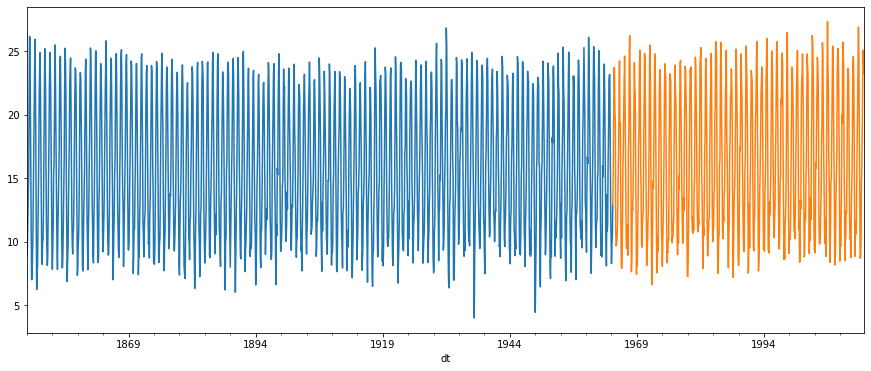

In [15]:
# Data already in months, lets see what our data looks like
plt.figure(figsize= (15,6))
train.AverageTemperature.plot()
test.AverageTemperature.plot()

In [16]:
y = train.AverageTemperature

Text(0.5, 1.0, 'Avg Temp By Month')

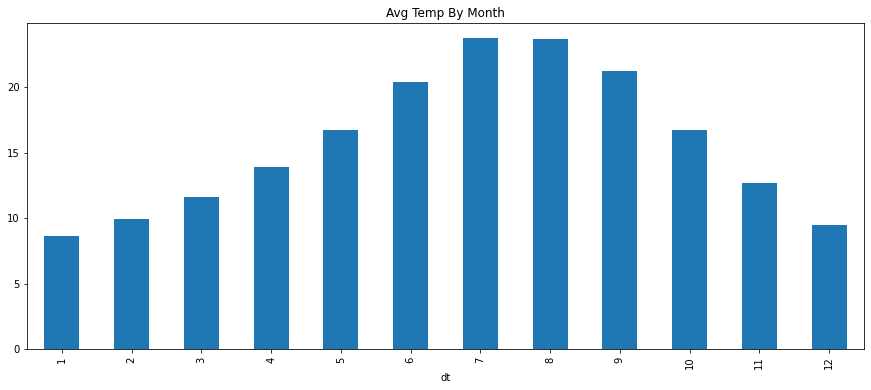

In [17]:
##avg temp by month
plt.figure(figsize=(15,6))
y.groupby(y.index.month).mean().plot.bar()
plt.title('Avg Temp By Month')

In [18]:
# As expected, hotter during the summer months , colder in the winter months.

In [19]:
# Lets look at avg change in temperature every month as months go on

<AxesSubplot:xlabel='dt'>

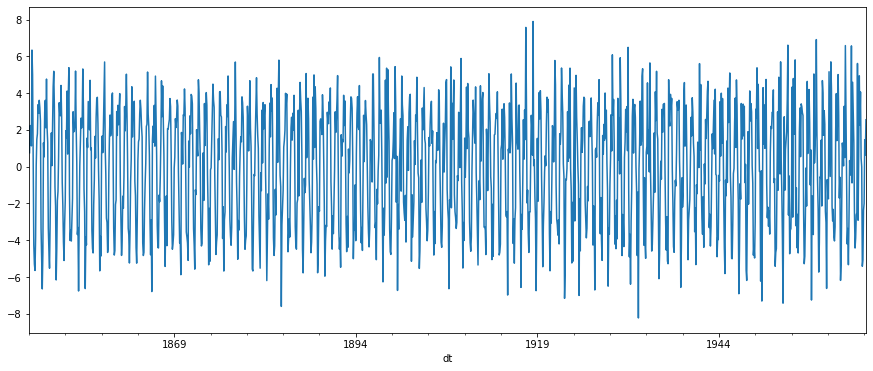

In [20]:
plt.figure(figsize=(15,6))
y.resample("M").mean().diff().plot()

<Figure size 1080x432 with 0 Axes>

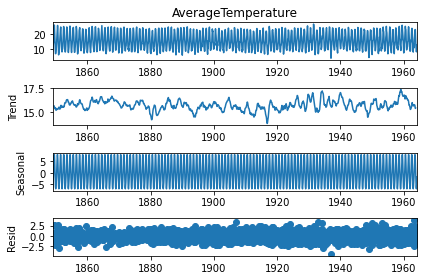

In [21]:
plt.figure(figsize=(15,6))
sm.tsa.seasonal_decompose(y).plot()
plt.show()

In [22]:
#year fequency, vs 5 years vs 10 year freq

<Figure size 1080x432 with 0 Axes>

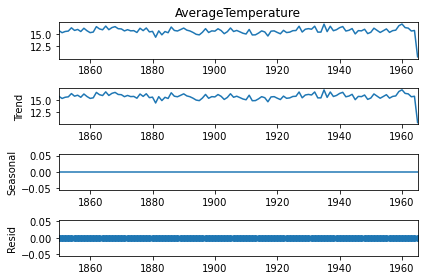

In [23]:
plt.figure(figsize=(15,6))
sm.tsa.seasonal_decompose(y.resample('Y').mean()).plot()
plt.show()

<Figure size 1080x432 with 0 Axes>

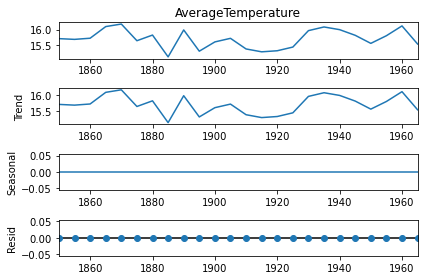

In [24]:
plt.figure(figsize=(15,6))
sm.tsa.seasonal_decompose(y.resample('5Y').mean()).plot()
plt.show()

<Figure size 1080x432 with 0 Axes>

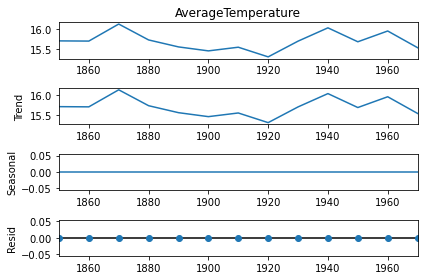

In [25]:
plt.figure(figsize=(15,6))
sm.tsa.seasonal_decompose(y.resample('10Y').mean()).plot()
plt.show()

In [26]:
# not much seasonality happening over the course of the years. we'll try to predict on a month to month basis

## Forcasting 
- Here we'll use info found in train to try to predict test. then use test to predict the next 5 years out

<AxesSubplot:xlabel='dt'>

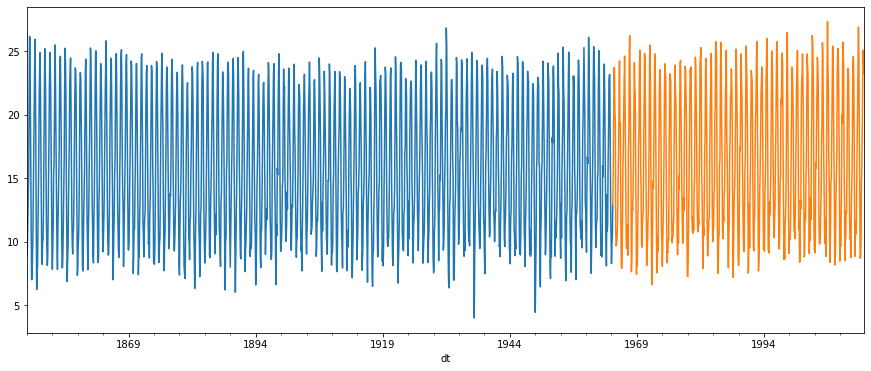

In [27]:
plt.figure(figsize= (15,6))
train.AverageTemperature.plot()
test.AverageTemperature.plot()

In [28]:
#df to hold results
results = pd.DataFrame(columns=['Model_type', 'RMSE'])
results

Empty DataFrame
Columns: [Model_type, RMSE]
Index: []

##### Last observed 

In [29]:
last_temp = round(train['AverageTemperature'][-1:][0],2)

In [30]:
last_temp

12.94

In [31]:
yhat_df = pd.DataFrame({'AverageTemperature': [last_temp]}, index = test.index)

AverageTemperature --rmse:6.47218


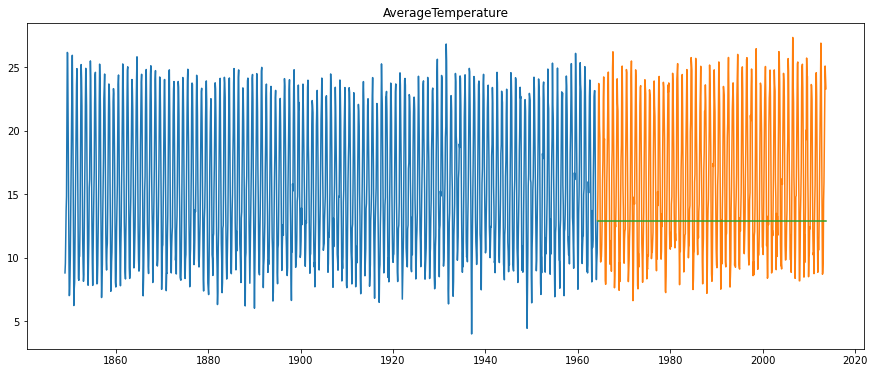

In [32]:
lo_rmse = evaluate.plot_and_eval(train,test,yhat_df, 'AverageTemperature')

In [33]:
a = {"Model_type":'Last observed ', 'RMSE':lo_rmse}
results = results.append(a, ignore_index=True)

##### Simple Average

In [34]:
avg_temp = round(train['AverageTemperature'].mean(),2)

In [35]:
yhat_df = pd.DataFrame({'AverageTemperature': [avg_temp]}, index = test.index)

AverageTemperature --rmse:5.57537


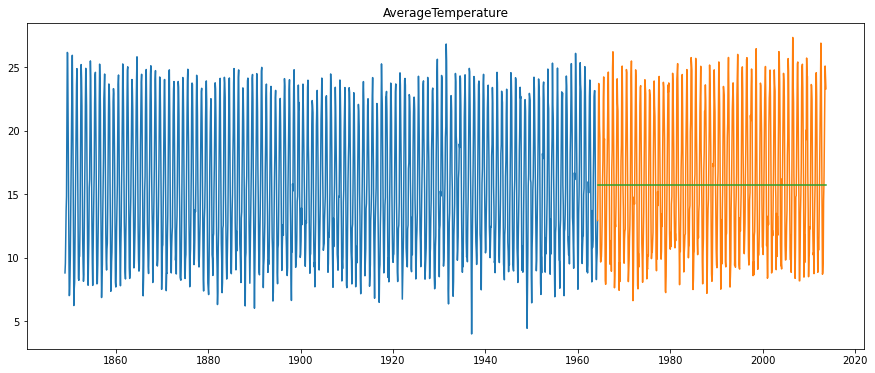

In [36]:
sa_rmse = evaluate.plot_and_eval(train,test,yhat_df, 'AverageTemperature')

In [37]:
b = {"Model_type":'Simple AVG ', 'RMSE':sa_rmse}
results = results.append(b, ignore_index=True)

##### Moving AVG

AverageTemperature --rmse:7.63399


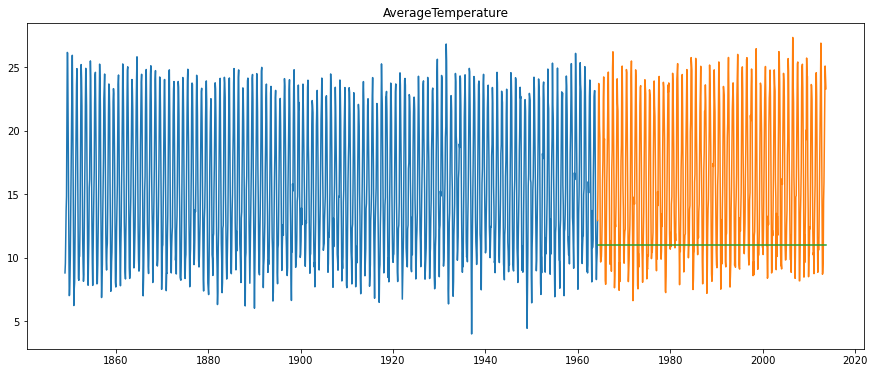

AverageTemperature --rmse:7.85022


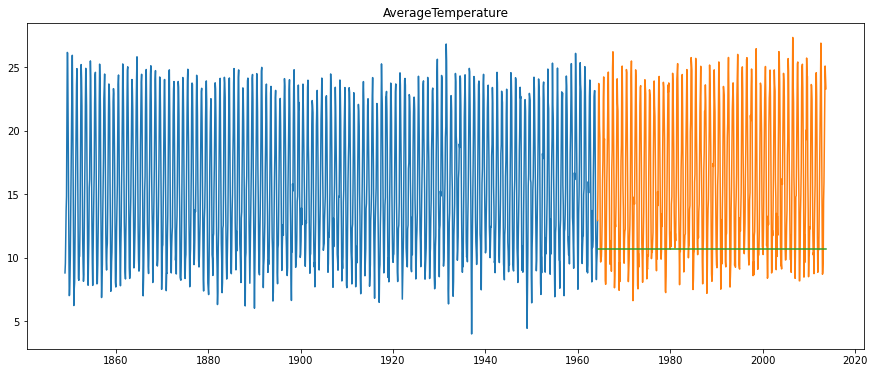

AverageTemperature --rmse:5.90139


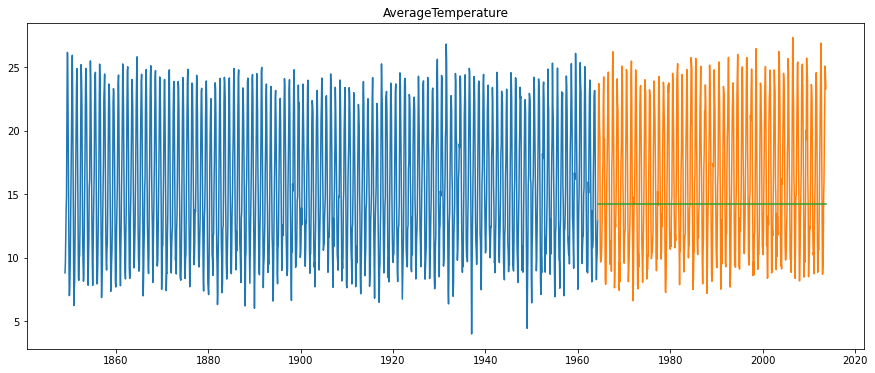

AverageTemperature --rmse:5.60056


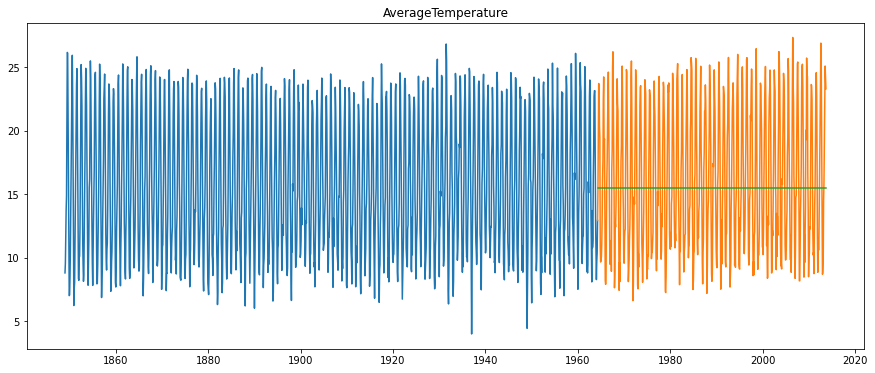

AverageTemperature --rmse:5.58290


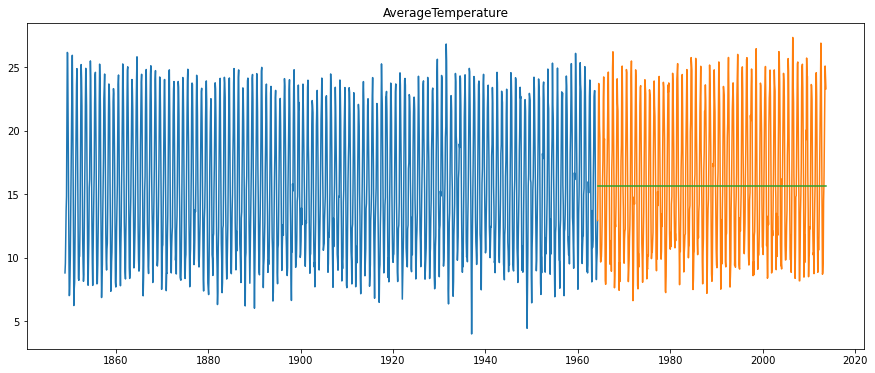

AverageTemperature --rmse:5.55251


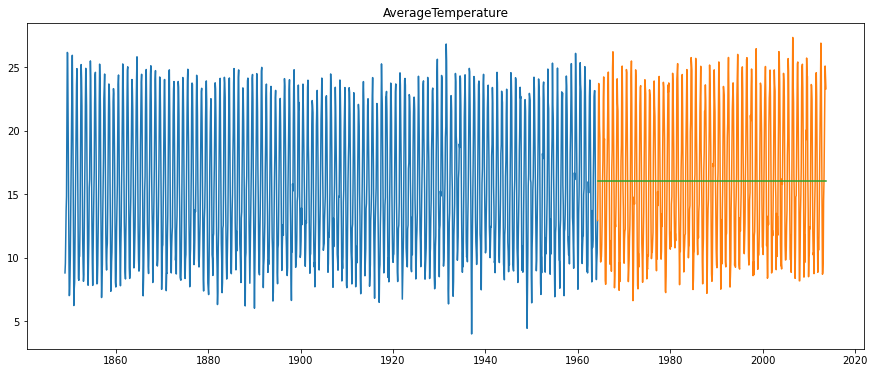

AverageTemperature --rmse:5.54703


AverageTemperature --rmse:5.55347


AverageTemperature --rmse:5.56612


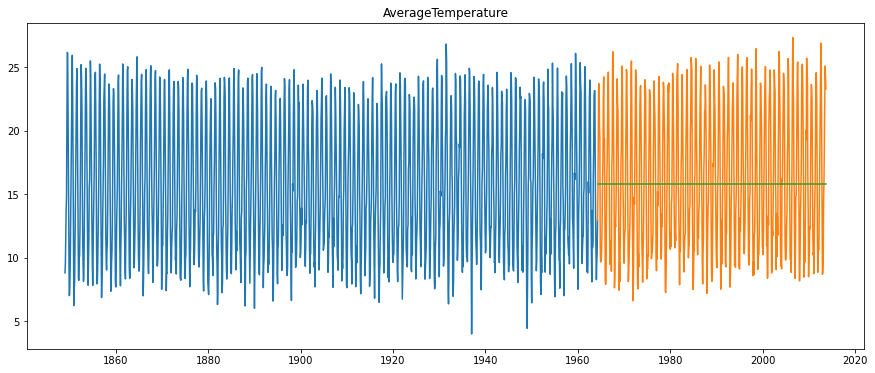

In [38]:
avgs = [3,6,9,12,36,60,72,120,240]
for i in avgs:
    roll_temp = round(train['AverageTemperature'].rolling(i).mean()[-1],2)
    yhat_df = pd.DataFrame({'AverageTemperature': [roll_temp]}, index = test.index)
    roll_rmse = evaluate.plot_and_eval(train, test, yhat_df, 'AverageTemperature')
    b = {"Model_type":'Rolling {} Months'.format(i), 'RMSE':roll_rmse}
    results = results.append(b, ignore_index=True)

##### Holts Linear Trend

AverageTemperature --rmse:5.76763


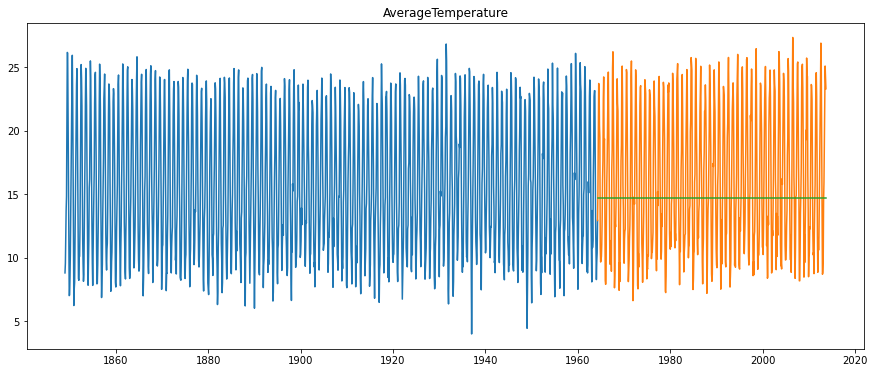

In [39]:
model = Holt(train.AverageTemperature, exponential=False, damped = True)
model = model.fit(optimized = True)
h_results = model.predict(start = test.index[0], end = test.index[-1])
yhat_df = pd.DataFrame({'AverageTemperature': [h_results[1]]}, index = test.index)
holt1_rmse = evaluate.plot_and_eval(train, test, yhat_df, 'AverageTemperature')
b = {"Model_type":'Holts 1'.format(i), 'RMSE':holt1_rmse}
results = results.append(b, ignore_index=True)

AverageTemperature --rmse:6.01088


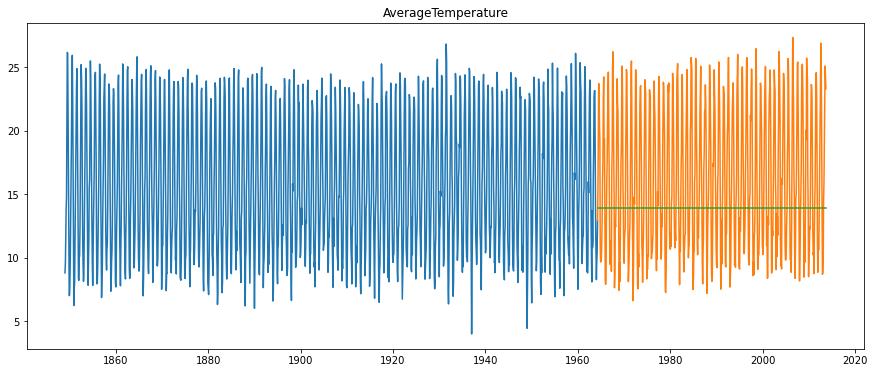

In [40]:
model = Holt(train.AverageTemperature, exponential=False)
model = model.fit(optimized = False, smoothing_level = .09, smoothing_slope= .09)
h_results = model.predict(start = test.index[0], end = test.index[-1])
yhat_df = pd.DataFrame({'AverageTemperature': [h_results[1]]}, index = test.index)
holt2_rmse = evaluate.plot_and_eval(train, test, yhat_df, 'AverageTemperature')
b = {"Model_type":'Holts 2'.format(i), 'RMSE':holt2_rmse}
results = results.append(b, ignore_index=True)

In [41]:
results

Model_type      RMSE
0       Last observed   6.472177
1          Simple AVG   5.575369
2     Rolling 3 Months  7.633989
3     Rolling 6 Months  7.850219
4     Rolling 9 Months  5.901393
5    Rolling 12 Months  5.600557
6    Rolling 36 Months  5.582900
7    Rolling 60 Months  5.552512
8    Rolling 72 Months  5.547026
9   Rolling 120 Months  5.553467
10  Rolling 240 Months  5.566120
11             Holts 1  5.767629
12             Holts 2  6.010879

### Previous 4 year Cycle
- We'll check to see which 4 year cycle is able to predict 2010 - 2013 with the least margin of error

In [42]:
df.index.min(), df.index.max()

(Timestamp('1849-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

In [43]:
#how 4 year spans are in are dataset? (1 for test case)
(2013 - 1849) / 4 - 1

40.0

In [44]:
#here we'll check to see which previous 4 year span is able to predict 2010 - 2013 the best

In [45]:
#resplit data 
train = df[:'2009']
test = df['2009':]

#seems like some of our years are missing data from october, novemeber and december
# for this scope we will predict jan - sept
train = train[~train.index.month.isin([10, 11, 12])]
test = test[~test.index.month.isin([10, 11, 12])]

AverageTemperature --rmse:1.78601


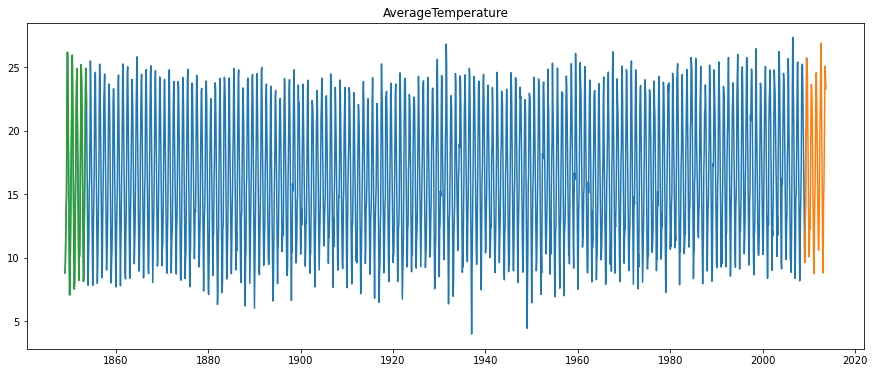

AverageTemperature --rmse:1.75218


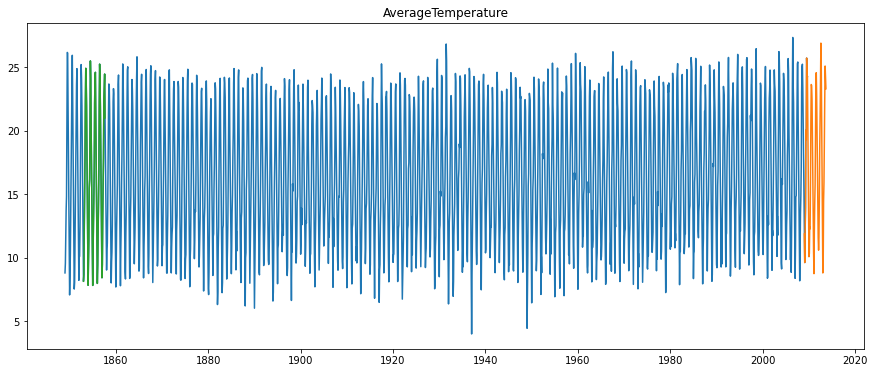

AverageTemperature --rmse:1.80815


AverageTemperature --rmse:1.51046


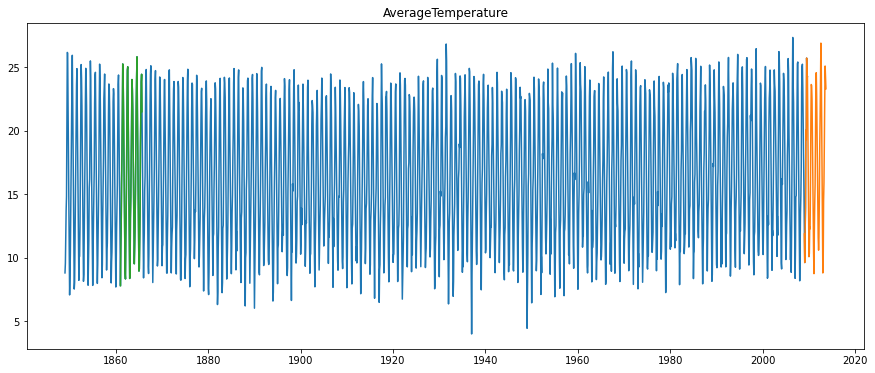

AverageTemperature --rmse:1.51920


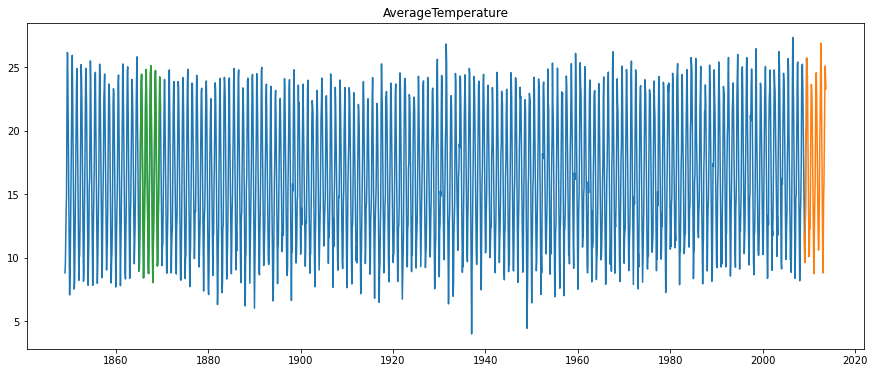

AverageTemperature --rmse:1.65734


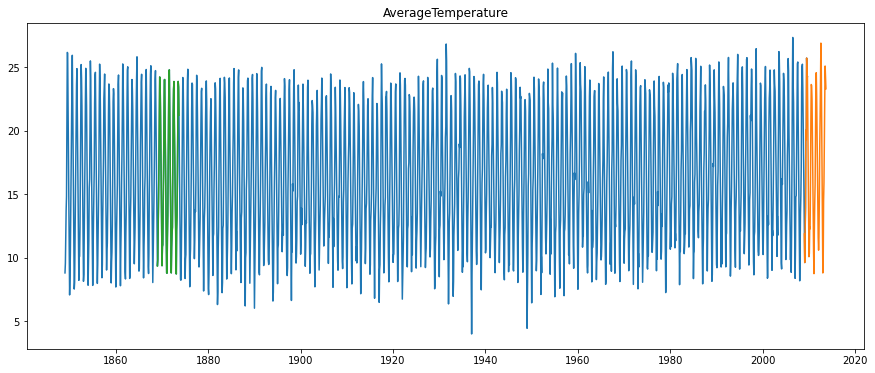

AverageTemperature --rmse:1.78211


AverageTemperature --rmse:2.05483


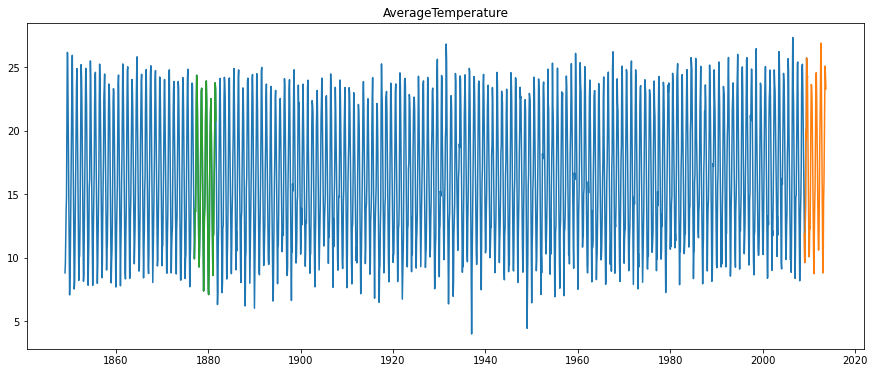

AverageTemperature --rmse:1.93712


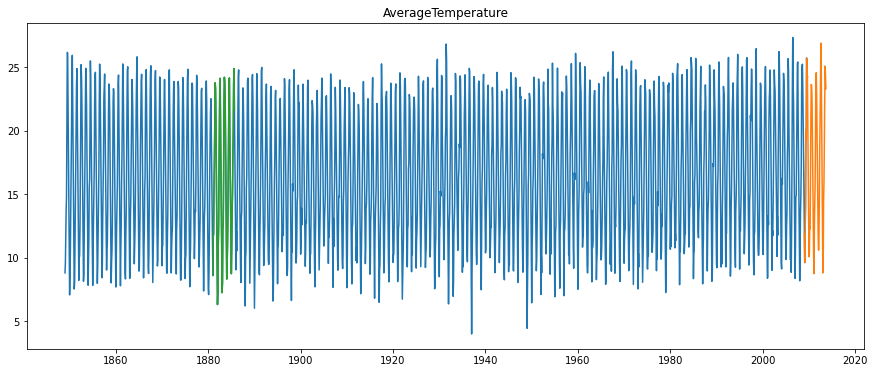

AverageTemperature --rmse:1.63402


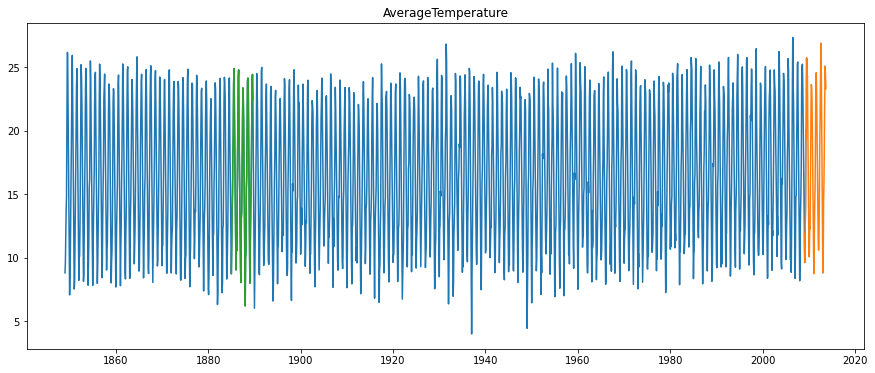

AverageTemperature --rmse:2.08376


AverageTemperature --rmse:2.26523


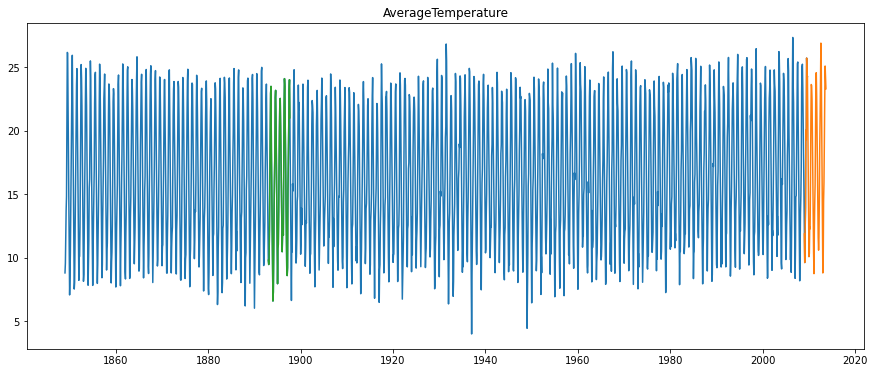

AverageTemperature --rmse:2.19159


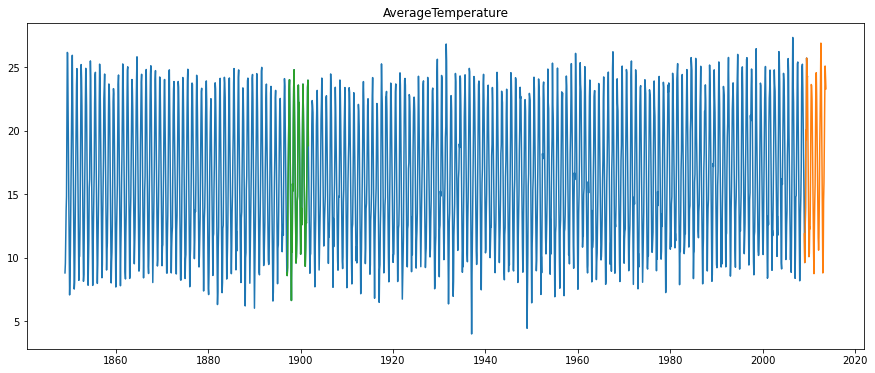

AverageTemperature --rmse:1.97523


AverageTemperature --rmse:2.27992


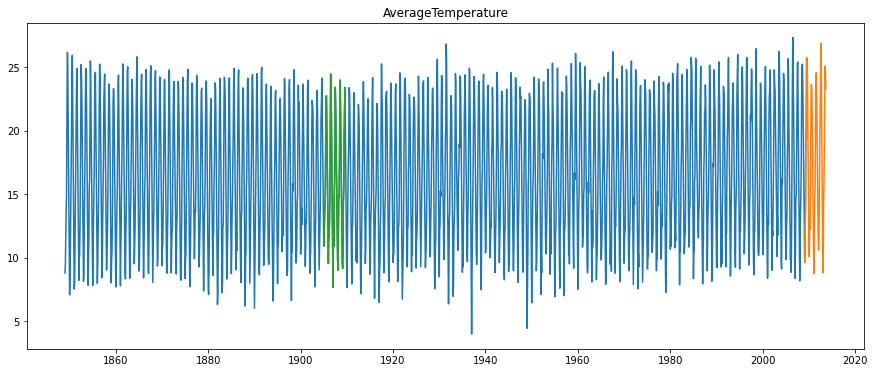

AverageTemperature --rmse:2.34116


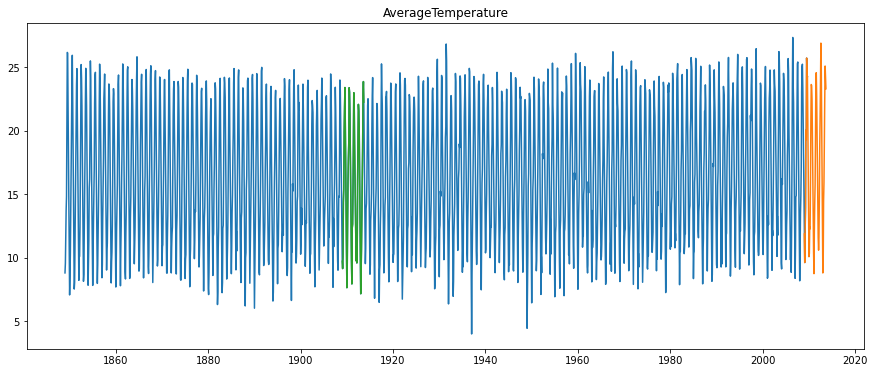

AverageTemperature --rmse:2.36319


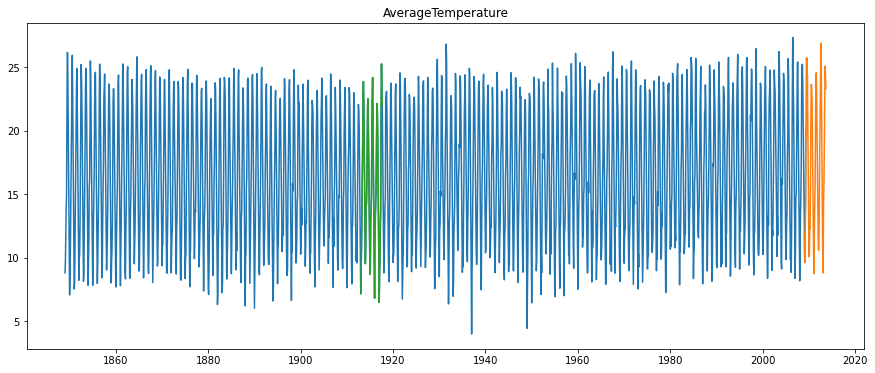

AverageTemperature --rmse:2.18695


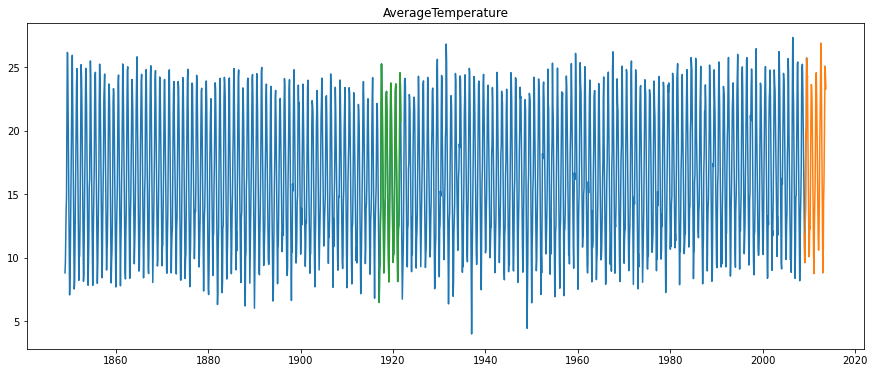

AverageTemperature --rmse:2.06655


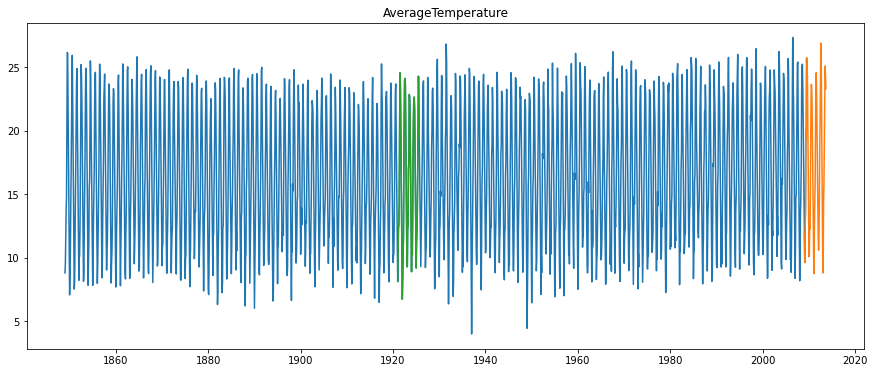

AverageTemperature --rmse:1.99508


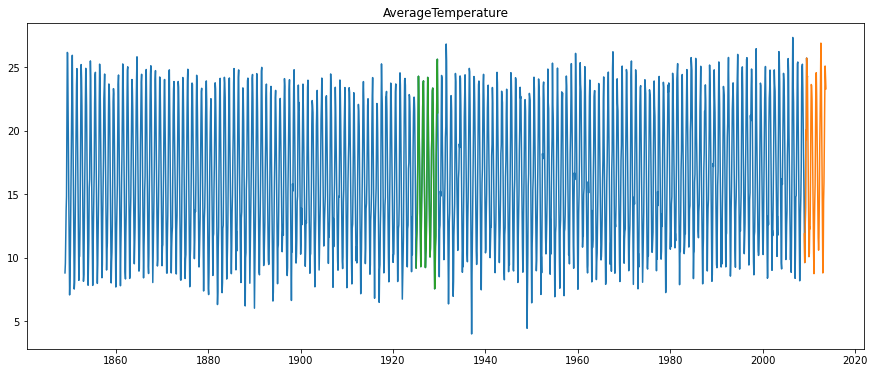

AverageTemperature --rmse:2.36747


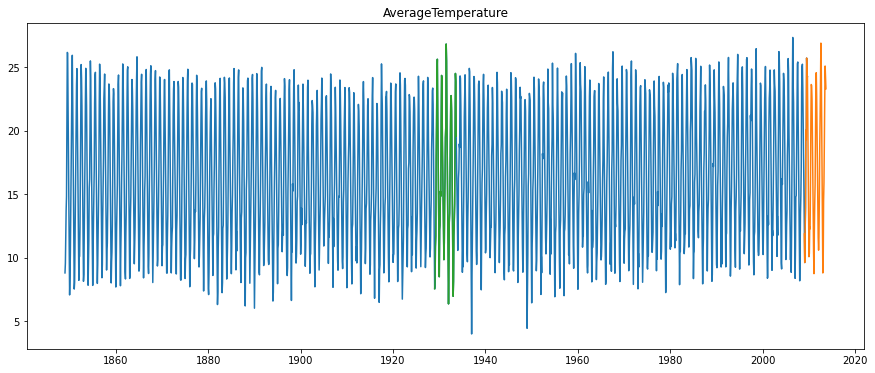

AverageTemperature --rmse:2.23547


AverageTemperature --rmse:2.07072


AverageTemperature --rmse:2.05041


AverageTemperature --rmse:2.02644


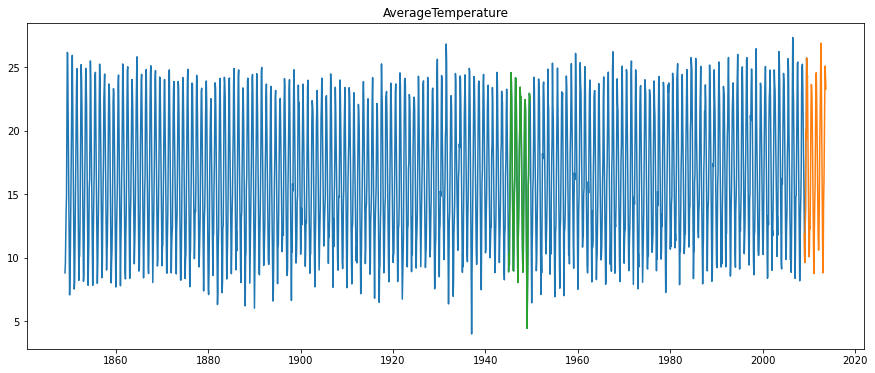

AverageTemperature --rmse:2.38785


AverageTemperature --rmse:2.01530


AverageTemperature --rmse:2.10546


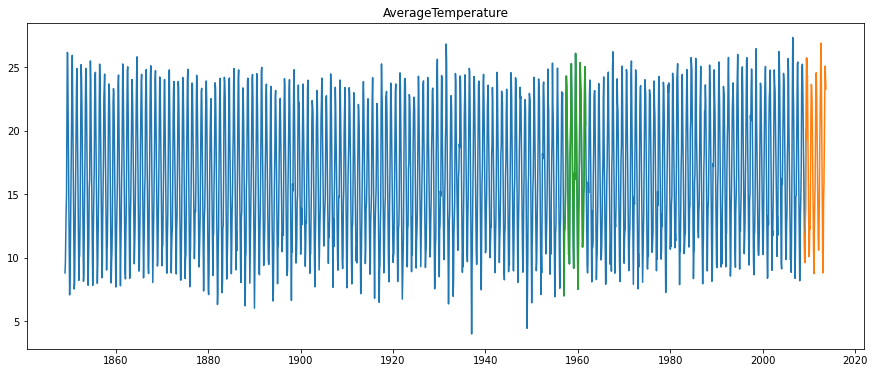

AverageTemperature --rmse:2.40934


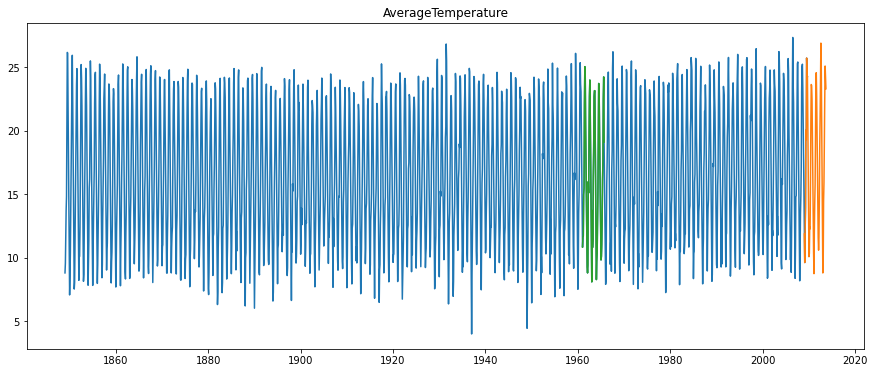

AverageTemperature --rmse:2.20296


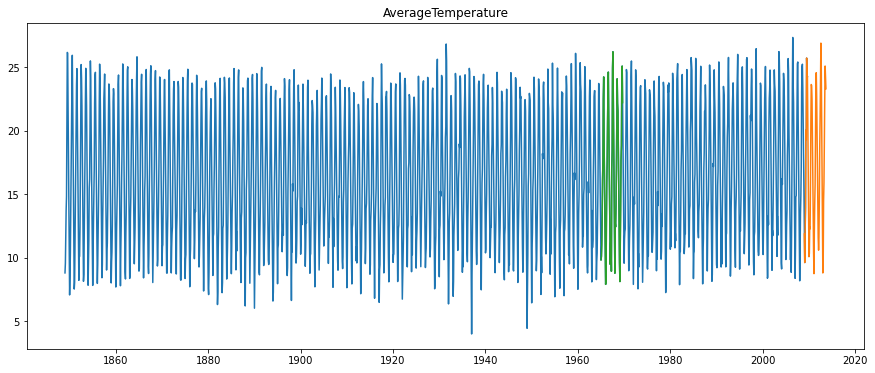

AverageTemperature --rmse:1.76950


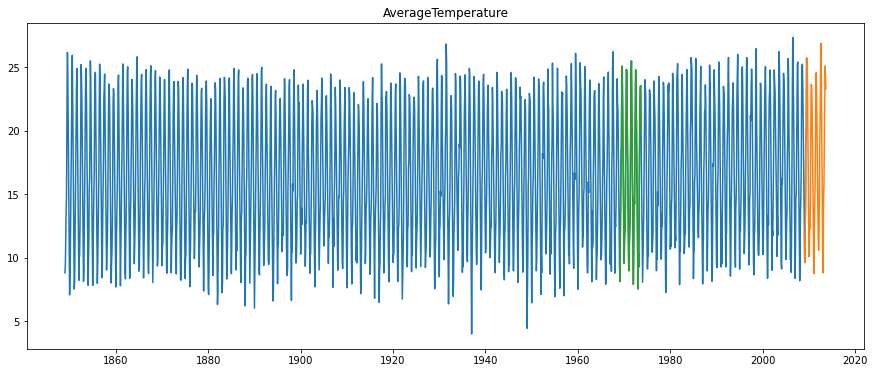

AverageTemperature --rmse:2.13029


AverageTemperature --rmse:1.99353


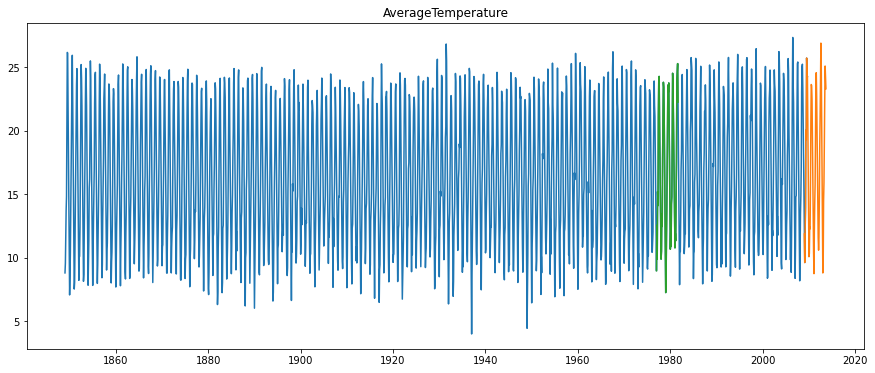

AverageTemperature --rmse:1.67619


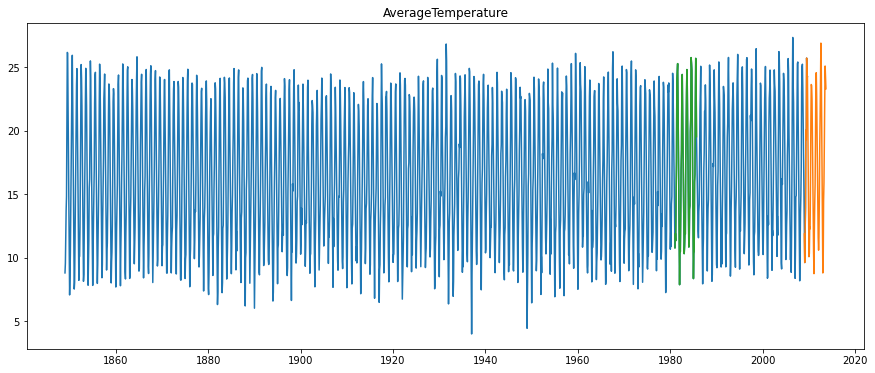

AverageTemperature --rmse:2.02161


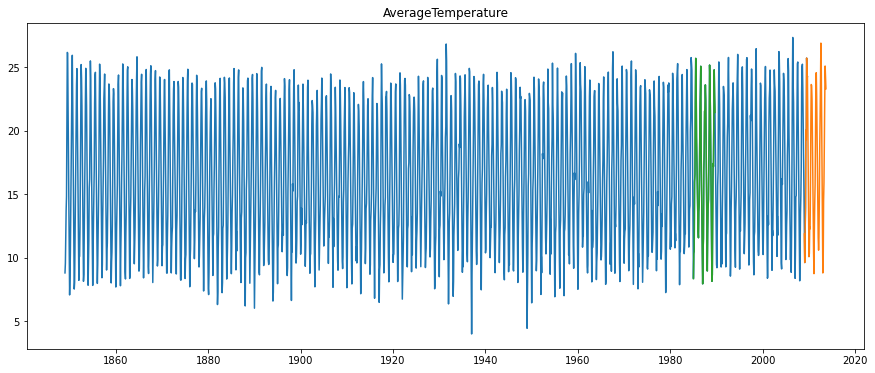

AverageTemperature --rmse:1.66594


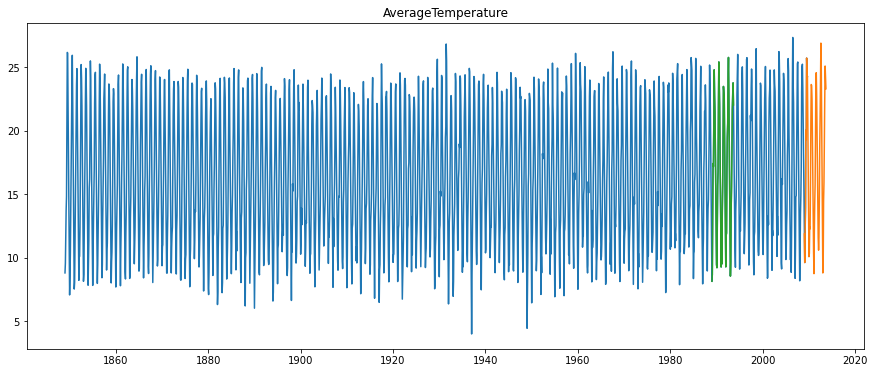

AverageTemperature --rmse:1.60824


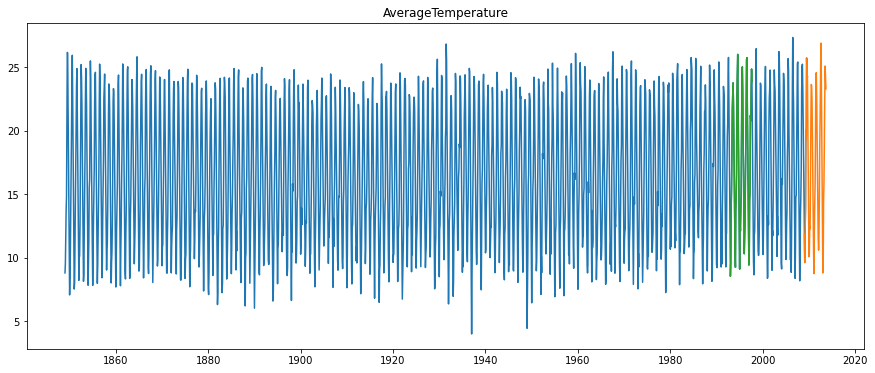

AverageTemperature --rmse:1.46390


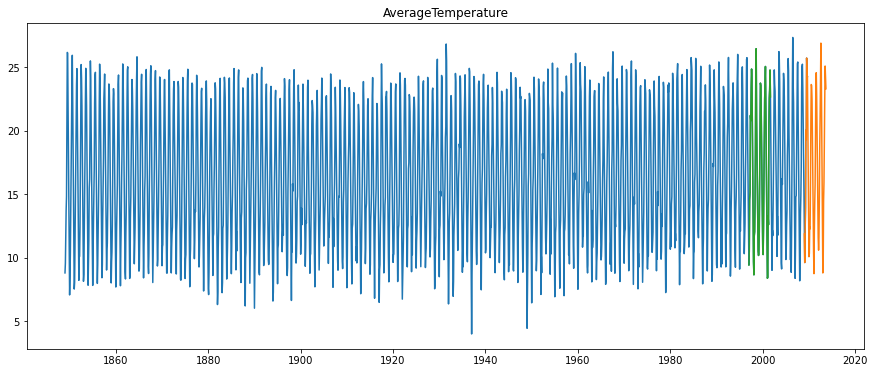

AverageTemperature --rmse:1.84020


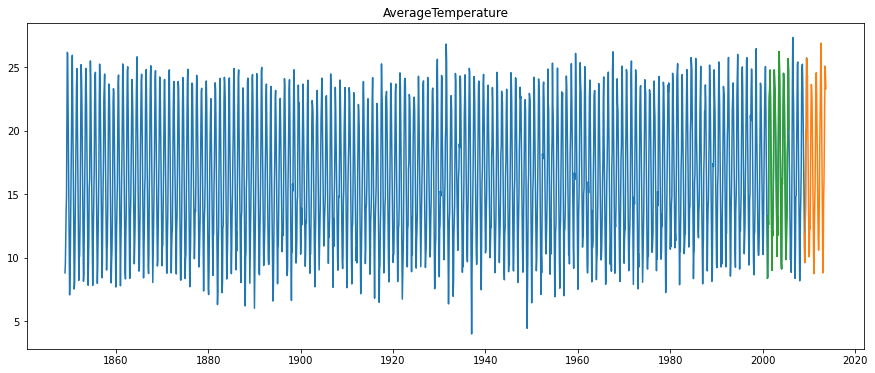

AverageTemperature --rmse:1.91150


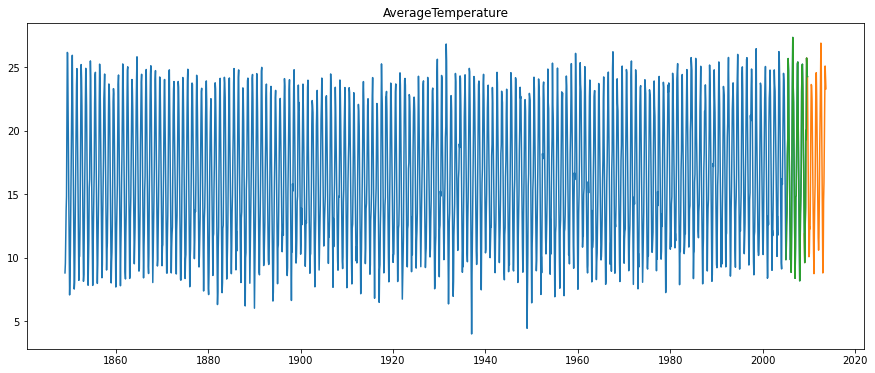

In [46]:
start = train.index.year.min()
for i in range(1,41):
    end = start + 4
    cycle = train[str(start):str(end)]
    yhat_df = pd.DataFrame({'AverageTemperature': [cycle.AverageTemperature]}, index = test.index)
    cycle_rmse = evaluate.plot_and_eval(train, test, cycle, 'AverageTemperature')
    b = {"Model_type":'{} to {}'.format(start,end-1), 'RMSE':cycle_rmse}
    results = results.append(b, ignore_index=True)
    start = end

In [47]:
results

Model_type      RMSE
0       Last observed   6.472177
1          Simple AVG   5.575369
2     Rolling 3 Months  7.633989
3     Rolling 6 Months  7.850219
4     Rolling 9 Months  5.901393
5    Rolling 12 Months  5.600557
6    Rolling 36 Months  5.582900
7    Rolling 60 Months  5.552512
8    Rolling 72 Months  5.547026
9   Rolling 120 Months  5.553467
10  Rolling 240 Months  5.566120
11             Holts 1  5.767629
12             Holts 2  6.010879
13        1849 to 1852  1.786012
14        1853 to 1856  1.752176
15        1857 to 1860  1.808152
16        1861 to 1864  1.510455
17        1865 to 1868  1.519200
18        1869 to 1872  1.657343
19        1873 to 1876  1.782108
20        1877 to 1880  2.054827
21        1881 to 1884  1.937122
22        1885 to 1888  1.634018
23        1889 to 1892  2.083755
24        1893 to 1896  2.265229
25        1897 to 1900  2.191590
26        1901 to 1904  1.975225
27        1905 to 1908  2.279916
28        1909 to 1912  2.341156
29        1913 to 1916  2.363186
30        1917 to 1920  2.186952
31        1921 to 1924  2.066554
32        1925 to 1928  1.995080
33        1929 to 1932  2.367468
34        1933 to 1936  2.235467
35        1937 to 1940  2.070720
36        1941 to 1944  2.050413
37        1945 to 1948  2.026438
38        1949 to 1952  2.387847
39        1953 to 1956  2.015301
40        1957 to 1960  2.105460
41        1961 to 1964  2.409340
42        1965 to 1968  2.202961
43        1969 to 1972  1.769500
44        1973 to 1976  2.130288
45        1977 to 1980  1.993525
46        1981 to 1984  1.676192
47        1985 to 1988  2.021608
48        1989 to 1992  1.665936
49        1993 to 1996  1.608244
50        1997 to 2000  1.463902
51        2001 to 2004  1.840202
52        2005 to 2008  1.911504

In [48]:
results.loc[results["RMSE"] == results.RMSE.min()]

Model_type      RMSE
50  1997 to 2000  1.463902

#### Seems like 1997-2000 was the most similar year span to 2010-2013, if theres a trend then 2014-2017 should look similar to a mix beteen 1997-2001 and 2002-2005?

In [61]:
#use 1997-2000 and the and the mean of the next 4 years (36 months as were only calculating jan-sept) as a buffer
future_predicition = train['1997':'2000'] + train.diff(36).mean()
future_predicition = future_predicition.shift(17, freq='Y')

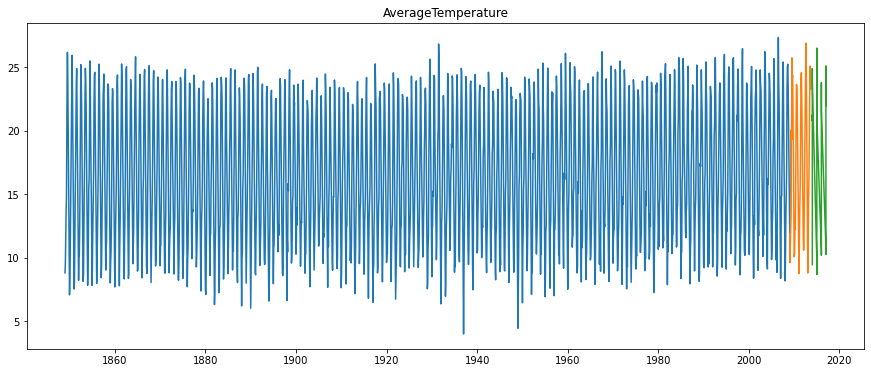

In [62]:
evaluate.final_plot(train, test, future_predicition, "AverageTemperature")